# Urban Sounbd Classification
## Machine Learning II - Project

Developed by:
- Beatriz Pereira, up202304769
- Carolina Leite, up202307856
- Lara Gonçalves, up202307857

Teacher: Francesco Renna

30 November 2025

------

## Table of Contents <a name = "contents"></a>
1. [Introduction](#introduction)
2. [Data Understanding](#data_understanding)
2. [Librosa vs Scipy.io](#librosa_vs_scipy.io)
3. [Exploratory Data Analysis](#exploratory_data_analysis)
4. [Data Preprocessing](#data_preprocessing)
5. [Modeling](#modeling)


## Introduction <a name = "introduction"></a>
[Back to top](#contents)

The objective of this project is to develop algorithms for the analysis of urban sound data, using the UrbanSound8K dataset. This dataset contains sound clips labeled into 10 distinct categories, allowing the development of models capable of classifying everyday urban sounds.

In this assignment, we implement two deep learning classifiers:
- **Convolutional Neural Network (CNN)** - used to extract time-frequency features from spectrogram representations
- **Recurrent Neural Network (RNN)** - used to capture long-range temporal dependencies present in audio signals.

By evaluating both approaches, we aim to explore different methods for representing and modeling sound data, comparing their performance and identifying the strengths and limitations of each model in the context of urban sound classification.

The following libraries and functionalities were necessary to complete the project:

In [1]:
# Audio Processing
import librosa
import librosa.display
import soundfile as sf
from scipy.io import wavfile as wav
import scipy.stats

# Data Manipulation
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

# Machine Learning Tools
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder

## 2. Data Understanding<a name="data_understanding"></a>
[Back to top](#contents)

The dataset consists of 8,732 labeled sound excerpts, each lasting up to 4 seconds, categorized into 10 distinct classes:
- 0 = air_conditioner
- 1 = car_horn
- 2 = children_playing
- 3 = dog_bark
- 4 = drilling
- 5 = engine_idling
- 6 = gun_shot
- 7 = jackhammer
- 8 = siren
- 9 = street_music

The sound classes in the UrbanSound and UrbanSound8K datasets are derived from the UrbanSound taxonomy, as presented on the https://urbansounddataset.weebly.com/taxonomy.html

Below is an image showcasing the taxonomy structure from the referenced site:

<p align="center">
  <img src="images/urban_sound_taxonomy.png">
</p>

All audio excerpts are derived from field recordings uploaded to http://www.freesound.org/

The dataset comprises 8,732 urban sound audio files in WAV format. The sampling rate, bit depth, and number of channels correspond to those of the original files uploaded to Freesound, which may vary across different recordings.

In addition to the audio excerpts, a CSV file containing metadata for each excerpt is also included.

This is a short explanation of the csv:

| Name of the Column | Brief Explanation                                                                                       |
|--------------------|--------------------------------------------------------------------------------------------------------|
| slice_file_name    | The name of the audio file, formatted as [fsID]-[classID]-[occurrenceID]-[sliceID].wav.              |
| fsID               | The Freesound ID of the recording from which this excerpt (slice) is taken.                           |
| start              | The start time of the slice in the original Freesound recording.                                      |
| end                | The end time of the slice in the original Freesound recording.                                        |
| salience           | A subjective salience rating of the sound (1 = foreground, 2 = background).                           |
| fold               | The fold number (1-10) to which this file has been allocated.                                         |
| classID            | A numeric identifier of the sound class (0-9) as listed above.                                        |
| [occurrenceID]     | A numeric identifier to distinguish different occurrences of the sound within the original recording. |
| [sliceID]          | A numeric identifier to distinguish different slices taken from the same occurrence.                 |


## Librosa vs Scipy.io <a name = "librosa_vs_scipy.io"></a>
[Back to top](#contents)

When working with audio data in Python, different libraries can be used to load and process '.wav' files. In this project, we compare **Librosa** and **SciPy.io**, as both are commonly used for audio manipulation but offer different capabilities. 

### Librosa

Librosa is a library specialized in audio analysis and manipulation for machine learning and digital signal processing. It provides a wide range of tools aimed at extracting audio features and representations.

**Advantages:**
- Supports multiple audio formats ('.wav', '.mp3', etc.).
- Advanced feature extraction tools: Mel Spectrograms, MFCCs, Chromagrams.
- Easy audio manipulation (resampling, padding, normalization).
- Easy integration with visualization utilities (spectrograms, MFCCs).

**Disadvantages:**
- Slower for simple operations (loading and saving audio).
- Steeper learning curve for beginners.
- Depends on external libraries (audioread, ffmpeg).

### SciPy.io

SciPy.io is part of the SciPy library and is used to read and write '.wav' files. Useful for basic audio manipulation tasks.

**Advantages:**
- Simple, fast, and efficient for loading and saving '.wav' files.
- Direct integration with NumPy for basic manipulation.

**Disadvantages:**
- Limited to '.wav' files.
- Does not support advanced feature extraction.
- No resampling, padding, or visualization utilities.

In [5]:
filename = r"UrbanSound8K/audio/fold1/7061-6-0-0.wav"

In [6]:
librosa_audio, librosa_sample_rate = librosa.load(filename)
scipy_sample_rate, scipy_audio = wav.read(filename)

In [7]:
print("Librosa Sample Wave Rate: ", librosa_sample_rate)
print("SciPy Sample Wave Rate: ", scipy_sample_rate)

Librosa Sample Wave Rate:  22050
SciPy Sample Wave Rate:  44100


In [8]:
print("Librosa Audio Signal", librosa_audio)
print("Librosa Audio Data Type: ", librosa_audio.dtype)
print()
print("SciPy Audio Signal", scipy_audio)
print("SciPy Audio Data Type: ", scipy_audio.dtype)

Librosa Audio Signal [-7.4505806e-09  2.9802322e-08  4.8428774e-08 ...  1.0127544e-05
  2.3271263e-05  7.0009992e-06]
Librosa Audio Data Type:  float32

SciPy Audio Signal [[0 0]
 [0 0]
 [0 0]
 ...
 [1 0]
 [1 1]
 [0 0]]
SciPy Audio Data Type:  int16


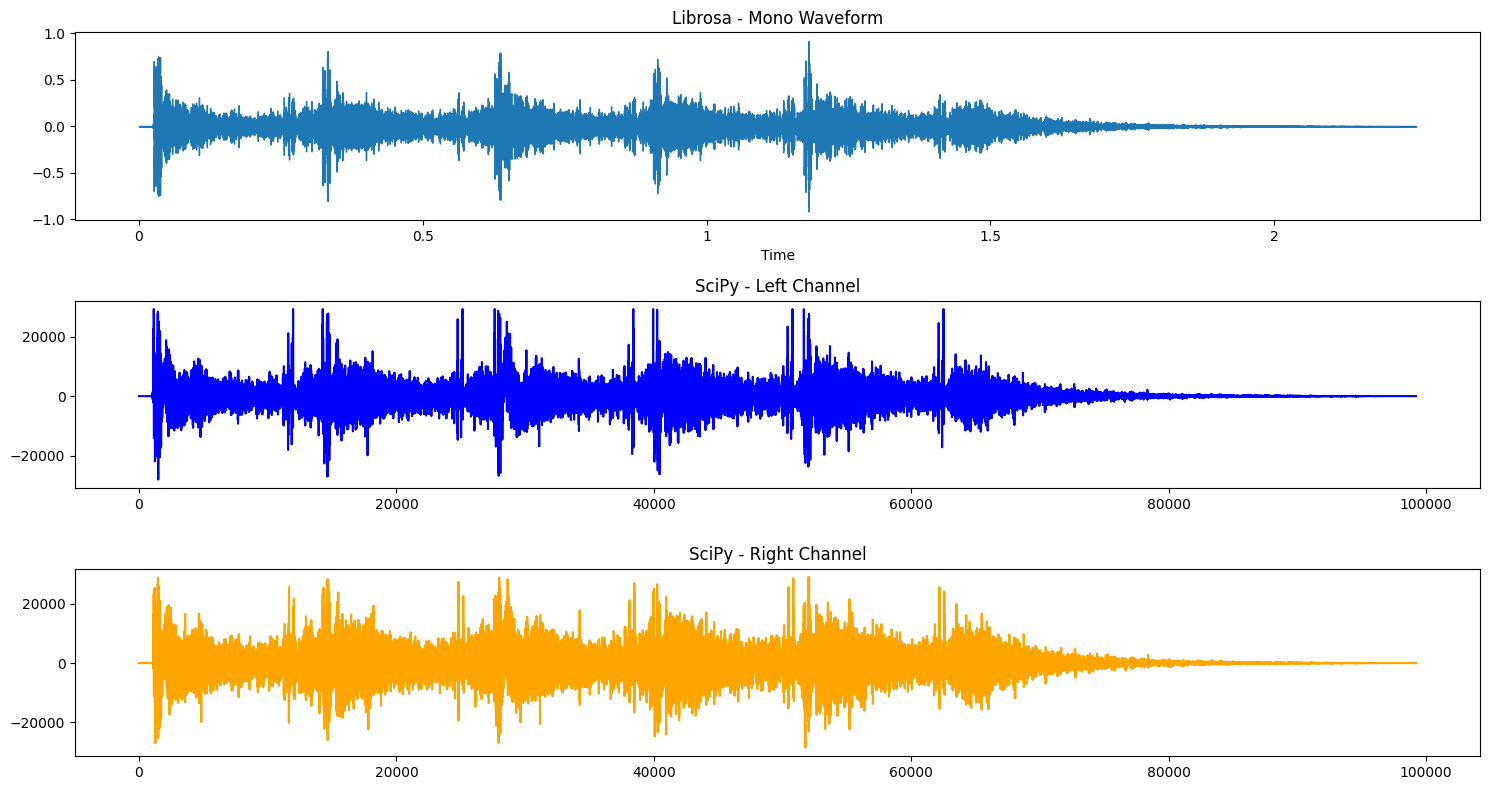

In [9]:
# Adjust the figure size to increase its height
plt.figure(figsize=(15, 8)) 

# Plot librosa mono waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(librosa_audio, sr=librosa_sample_rate)
plt.title("Librosa - Mono Waveform")

# Plot scipy stereo waveform (each channel separately if stereo)
# Plot left and rigth cannels in separate subplots
plt.subplot(3,1,2)
# Stereo
if scipy_audio.ndim > 1: 
    plt.plot(scipy_audio[:, 0], label = "Left Channel", color = 'blue')
    plt.title("SciPy - Left Channel")
    
    plt.subplot(3,1,3)
    plt.plot(scipy_audio[:, 1], label = "Right Channel", color = 'orange')
    plt.title("SciPy - Right Channel")
# Mono
else: 
    plt.plot(scipy_audio)
    plt.title("SciPy - Mono Waveform")

# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()

Librosa offers several advantages that are crucial for deep learning models:
- It automatically converts audio to a sampling rate of 22050 Hz, which simplifies model training;
- It converts audio into a single signal (mono sound) when needed, ensuring a consistent input format for neural networks.

For these reasons, **Librosa** was selected as the library for audio processing throughout this project.

## Exploratory Data Analysis<a name = "exploratory_data_analysis"></a>
[Back to top](#contents)

Before training the models, it is important to understand the characteristics of the dataset used in this project. 

In [10]:
# Import the file that contains the audio metadata 
path = "UrbanSound8K/metadata/UrbanSound8K.csv"
df = pd.read_csv(path)

In [11]:
df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [12]:
df.columns

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'],
      dtype='object')

As described on the dataset's official documentation page, this '.csv' file contains metadata related to the audio files included in the UrbanSound8K dataset. The meaning of each column is as follows:
- **slice_file_name**: The filename of the extracted audio segment.
- **fsID**: The Freesound ID of the original audio sample from which the slice was taken.
- **start**: The starting time (seconds) of the extracted segment within the original audio file.
- **end**: The ending time (seconds) of the extracted segment.
- **salience**: Indicates whether the sound is considered *foreground - 1* or *background - 2*.
- **fold**: The fold number assigned to the audio clip for the dataset's predefined 10-fold cross-validation split.
- **classID**: The numerical identifier associated with the sound category.
- **class**: The human-readable label of the sound category.

These metadata fields help us to identify each audio clip and properly prepare the dataset for model training.

Before performing a more detailed analysis, we first verify whether the dataset contains any issues that could compromise model training:

**Missing values**

In [13]:
missing = df.isnull().sum()
print(f"Missing values per columns: {missing}")

Missing values per columns: slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


The results show **no missing values** in any column, which means that all audio clips include complete metadata, which ensures that each sound can be correctly identified and classified.

**Duplicate values**

In [14]:
duplicates = df.duplicated().sum()
print(f"Duplicates in the dataset: {duplicates}")

Duplicates in the dataset: 0


There are **no duplicate values** in dataset. Each entry represents a unique audio segment, even when multiple segments originate from the same original recording.

Data Consistency

Although no issues were detected in the metadata, it is necessary to verify whether dataset is consistent. To do so, we performed a verification step by iterating through all the metada entries and checking whether each referenced audio file exists in the corresponding folder.

In [15]:
audios_dir = r"UrbanSound8K/audio"

Let's start by testing if all the audio files described in the metadata are located in the correct folders:

In [16]:
# Initialize list of missing files
missing_files = []
for index, row in df.iterrows():
    # Build the expected file path
    fold = row["fold"]
    folder_name = "fold" + str(fold)
    file_name = row["slice_file_name"]
    file_path = os.path.join(audios_dir, folder_name, file_name)

    # Check if file exists
    if not os.path.isfile(file_path):
        missing_files.append(file_path)

# Show missing files
if missing_files:
    print(f"Missing files ({len(missing_files)}):")
    for file in missing_files:
        print(file)
else:
    print("Every file in the metadata exists in the audio directory.")

Every file in the metadata exists in the audio directory.


Since no missing files were detected, we confirm that tha dataset is fully consistent.

Now, let's check if there are any extra files in the different folds:

In [17]:
# Initialize list of extra files
extra_files = []

for fold in range(1, 11):
    folder_name = "folder" + str(fold)
    folder_path = os.path.join(audios_dir, folder_name)
    if os.path.exists(folder_path):
        files_in_folder = os.listdir(folder_path)
        audio_files = [f for f in files_in_folder if f.endswith('.wav')]
        expected_files = metadata[metadata['fold'] == fold]['slice_file_name'].tolist()
        for audio_file in audio_files:
            if audio_file not in expected_files:
                extra_files.append(os.path.join(folder_path, audio_file))

# Show extra files
if extra_files:
    print(f"Extra files ({len(extra_files)}):")
    for file in extra_files:
        print(file)
else:
    print("No extra files found in the audio directory.")

No extra files found in the audio directory.


### Class Distribution Visualization

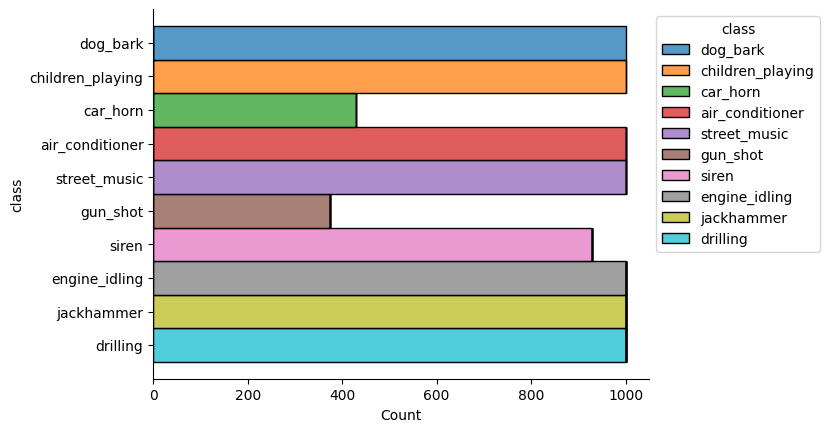

In [18]:
ax = sns.histplot(y='class', data=df, hue='class', multiple='stack')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [19]:
class_dict = df['class'].value_counts(normalize=True)
class_dict

class
dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: proportion, dtype: float64

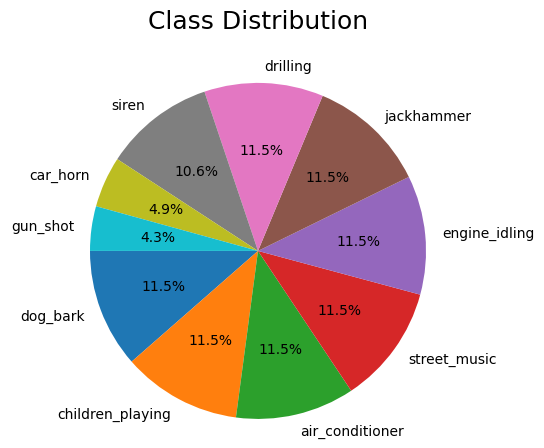

In [20]:
classes = class_dict.index
values = class_dict.values

fig,ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(values, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show(block=False)

Although the **'car_horn'** and **'gun_shot'** classes have fewer entries, and therefore fewer audio files of those types, the dataset appears to be minimally balanced, so no changes are necessary.

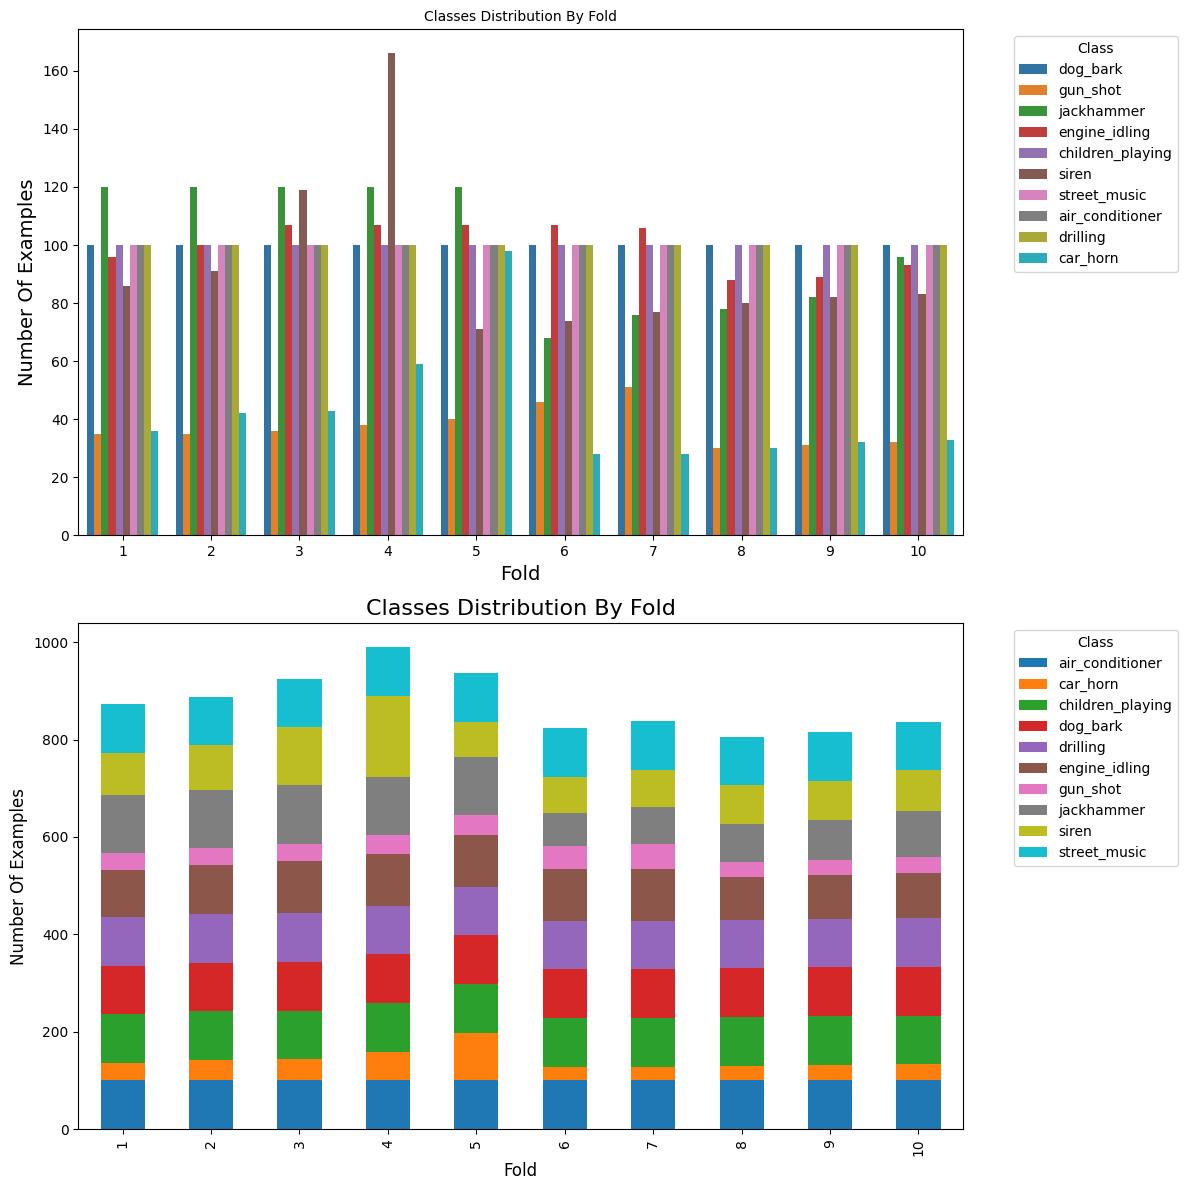

In [30]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Color palette
palette = sns.color_palette("tab10")

# First graphic: Countplot
sns.countplot(data=df,  x='fold', hue='class', palette=palette, ax=axs[0])
axs[0].set_title("Classes Distribution By Fold", fontsize=10)
axs[0].set_xlabel("Fold", fontsize=14)
axs[0].set_ylabel("Number Of Examples", fontsize=14)
axs[0].legend(title='Class', bbox_to_anchor=(1.05, 1), loc = "upper left")

# Count number of examples of each class by fold
class_fold_distribution = df.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Second graphics: Stacked bars
class_fold_distribution.plot(kind = 'bar', stacked=True, colormap='tab10', ax=axs[1])
axs[1].set_title("Classes Distribution By Fold", fontsize=16)
axs[1].set_xlabel("Fold", fontsize=12)
axs[1].set_ylabel("Number Of Examples", fontsize=12)
axs[1].legend(title='Class', bbox_to_anchor=(1.05, 1), loc = 'upper left')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [31]:
appended = []
for i in range(1, 11):
    appended.append(df[df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ['fold' + str(x) for x in range(1,11)]
class_distribution

class   index  jackhammer  dog_bark  children_playing  street_music  \
0       fold1         120       100               100           100   
1       fold2         120       100               100           100   
2       fold3         120       100               100           100   
3       fold4         120       100               100           100   
4       fold5         120       100               100           100   
5       fold6          68       100               100           100   
6       fold7          76       100               100           100   
7       fold8          78       100               100           100   
8       fold9          82       100               100           100   
9      fold10          96       100               100           100   

class  air_conditioner  drilling  engine_idling  siren  car_horn  gun_shot  
0                  100       100             96     86        36        35  
1                  100       100            100     91        42        35  
2                  100       100            107    119        43        36  
3                  100       100            107    166        59        38  
4                  100       100            107     71        98        40  
5                  100       100            107     74        28        46  
6                  100       100            106     77        28        51  
7                  100       100             88     80        30        30  
8                  100       100             89     82        32        31  
9                  100       100             93     83        33        32

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11140\1160308735.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='salience', palette='tab10')


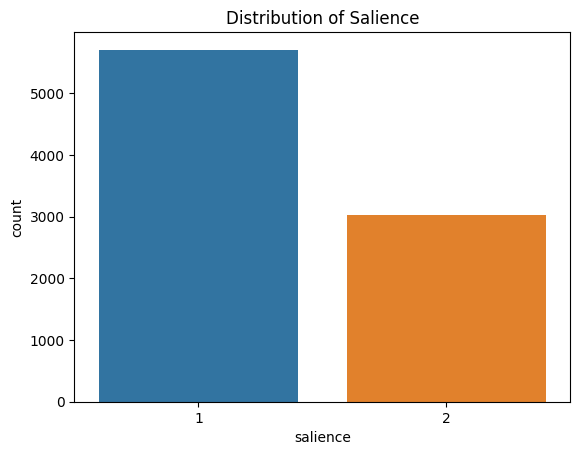

In [33]:
sns.countplot(data=df, x='salience', palette='tab10')
plt.title('Distribution of Salience')
plt.show()

Audio Duration

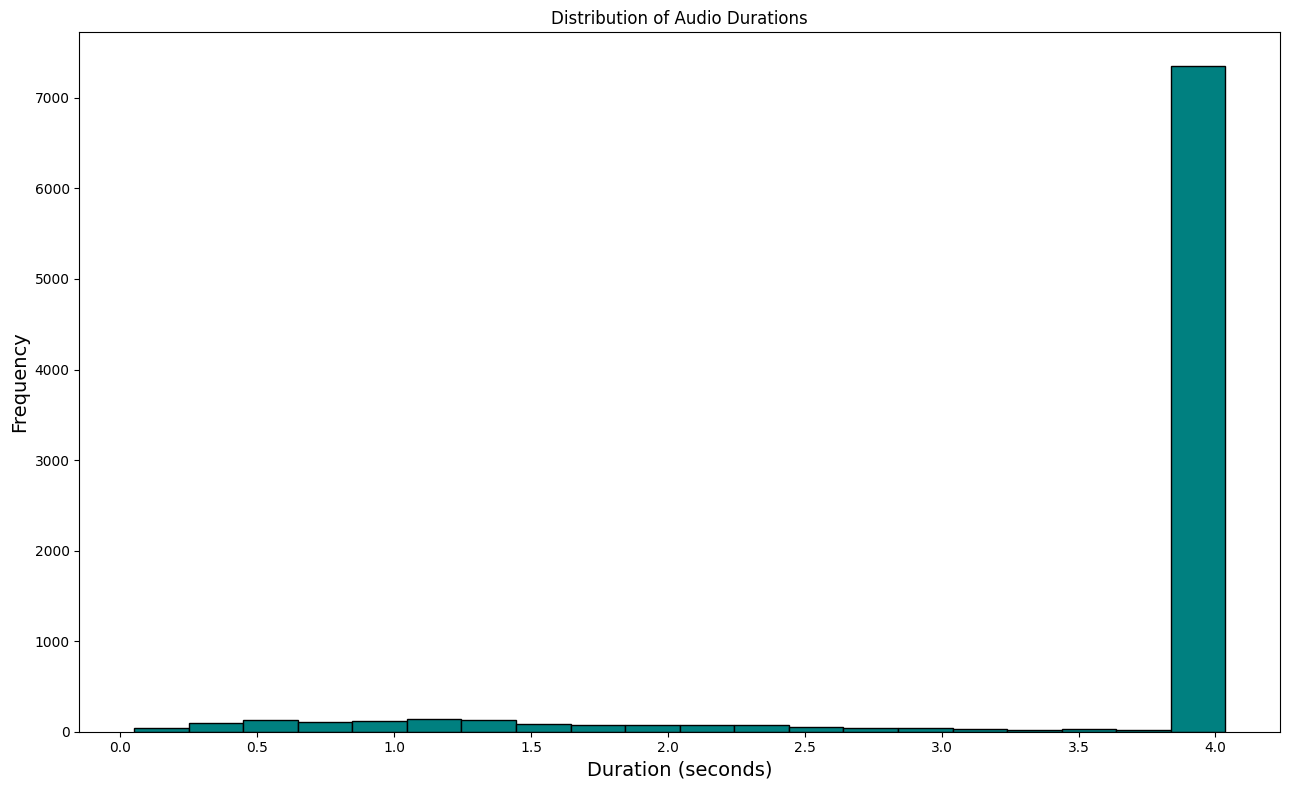

In [34]:
# List For Storing Durations
durations = []

for index, row in df.iterrows():
    fold = row["fold"]
    fold_name = "fold" + str(fold)
    file_name = row["slice_file_name"]
    file_path = os.path.join(audios_dir, fold_name, file_name)

    if os.path.isfile(file_path):
        y, sr = librosa.load(file_path, sr=None)
        durations.append(librosa.get_duration(y=y, sr=sr))
    else:
        print(f"File not found: {file_path}")


plt.figure(figsize=(13,8))
plt.hist(durations, bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize = 14)
plt.tight_layout()
plt.show()

Acessing the audio data

In [35]:
from collections import defaultdict
import os
import librosa

durations = defaultdict(list)  # chave = (fold, classID)

# Percorrer os 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    
    if os.path.exists(fold_path):
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                
                file_path = os.path.join(fold_path, file_name)
                
                # Carregar áudio
                audio, sr = librosa.load(file_path, sr=None)
                duration = len(audio) / sr
                
                # Extrair classID correto (o segundo elemento)
                # Ex: 103074-7-1-4.wav → 7
                class_id = int(file_name.split("-")[1])
                
                # Guardar duração por fold + classID
                durations[(fold, class_id)].append(duration)

# Procurar inconsistências em cada fold e classe
inconsistencias = defaultdict(list)

for (fold, class_id), durs in durations.items():
    # Ver se algum áudio foge dos 4s
    if any(abs(d - 4.0) > 0.01 for d in durs):  # tolerância de 0,01s
        inconsistencias[(fold, class_id)] = [round(d, 3) for d in durs]

# Show results
if inconsistencias:
    print("\nClasses com ficheiros que NÃO têm 4 segundos (por fold):")
    for (fold, class_id), durs in inconsistencias.items():
        print(f"\nFold {fold} | Class {class_id}")
        print("Durações:", durs)
else:
    print("Todos os ficheiros têm exatamente 4 segundos.")



Classes com ficheiros que NÃO têm 4 segundos (por fold):

Fold 1 | Class 3
Durações: [4.0, 4.0, 4.0, 1.64, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.519, 4.0, 4.0, 4.0, 4.0, 2.59, 4.0, 4.0, 4.0, 0.489, 0.446, 2.77, 0.19, 3.45, 1.989, 1.677, 1.7, 0.239, 1.44, 0.21, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.658, 0.957, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.526, 1.027, 0.607, 0.387, 1.46, 0.46, 4.0, 1.09, 4.0, 4.0, 0.885, 1.715, 2.25, 1.216, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.48, 1.32, 0.416, 2.298, 1.726, 0.83]

Fold 1 | Class 6
Durações: [2.61, 3.146, 2.09, 2.53, 2.32, 2.41, 2.536, 3.176, 3.08, 3.14, 1.53, 1.807, 1.28, 1.83, 1.33, 1.93, 1.958, 1.958, 1.707, 2.08, 1.83, 1.68, 1.93, 1.139, 1.418, 1.317, 1.497, 1.418, 1.508, 1.35, 2.25, 0.87, 0.63, 1.327, 1.137]

Fold 1 | Class 7
Durações: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 1.38, 4.0, 4.0, 4.0, 4.0, 4.0,

#### There is four estrategies:
- **Zeropadding:** Ideal for maintaining the integrity of short audios.
- **Audio Repetition:** Works well for rhythmic or repetitive sounds.
- **Discard Short Audios:** Simple and effective when you can afford to lose some data.
- **Interpolation:** Suitable if you want to maintain consistency in the timing of the audio, but can change the way it sounds.

4 seconds.

In [36]:
from collections import defaultdict
import os
import librosa

# key = (fold, classID)
incorrect_counts = defaultdict(int)

for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    
    if os.path.exists(fold_path):
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                
                file_path = os.path.join(fold_path, file_name)
                
                # Load audio
                audio, sr = librosa.load(file_path, sr=None)
                duration = len(audio) / sr
                
                # Extract classID (second element in "xxx-classID-..." format)
                class_id = int(file_name.split("-")[1])
                
                # Check if duration is incorrect
                if abs(duration - 4.0) > 0.01:  
                    incorrect_counts[(fold, class_id)] += 1

# Display results grouped by fold
print("\n=== NUMBER OF AUDIO FILES WITH A DURATION DIFFERENT FROM 4 SECONDS ===\n")

folds_grouped = defaultdict(dict)

for (fold, class_id), count in incorrect_counts.items():
    folds_grouped[fold][class_id] = count

for fold in range(1, 11):
    print(f"\nFold {fold}:")
    if fold in folds_grouped:
        for class_id, count in sorted(folds_grouped[fold].items()):
            print(f"  Class {class_id} → {count} files")
    else:
        print("All audio files are 4 seconds long.")



=== NUMBER OF AUDIO FILES WITH A DURATION DIFFERENT FROM 4 SECONDS ===


Fold 1:
  Class 0 → 1 files
  Class 1 → 22 files
  Class 2 → 3 files
  Class 3 → 33 files
  Class 4 → 18 files
  Class 5 → 2 files
  Class 6 → 35 files
  Class 7 → 16 files

Fold 2:
  Class 0 → 1 files
  Class 1 → 26 files
  Class 2 → 2 files
  Class 3 → 36 files
  Class 4 → 33 files
  Class 5 → 2 files
  Class 6 → 34 files
  Class 7 → 19 files

Fold 3:
  Class 1 → 21 files
  Class 2 → 2 files
  Class 3 → 28 files
  Class 4 → 12 files
  Class 5 → 7 files
  Class 6 → 36 files
  Class 7 → 16 files
  Class 8 → 1 files

Fold 4:
  Class 1 → 23 files
  Class 2 → 3 files
  Class 3 → 36 files
  Class 4 → 10 files
  Class 5 → 3 files
  Class 6 → 34 files
  Class 7 → 62 files
  Class 8 → 8 files

Fold 5:
  Class 0 → 1 files
  Class 1 → 28 files
  Class 2 → 3 files
  Class 3 → 32 files
  Class 4 → 36 files
  Class 5 → 6 files
  Class 6 → 40 files
  Class 7 → 14 files
  Class 8 → 7 files

Fold 6:
  Class 1 → 18 files
  Class

**Justification for the Zeropadding Strategy to Normalize Audio Duration**

During the exploratory analysis, it became clear that several classes in UrbanSound8K contain clips significantly shorter than the target duration of 4 seconds. The most affected classes are **car_horn**, **dog_bark**, **gun_shot**, **drilling**, and **jackhammer**, all of which correspond to short, abrupt, or partially recorded acoustic events.

Since the project includes both CNN (1D and 2D) and RNN models, it is essential to ensure that all audio clips share the same duration while preserving their original temporal structure as much as possible. Among various possible strategies for duration normalization — such as audio repetition, mirroring, or interpolation — zero-padding was chosen, meaning that silence is appended to the end of each clip until it reaches 4 seconds.

The choice of zero-padding is justified for several reasons:

- It fully preserves the original acoustic content without altering the timbre, rhythm, or envelope of the sound;

- It avoids artificial distortions that may arise from techniques such as repetition (which would duplicate short events, creating unrealistic patterns) or interpolation (which modifies the true frequency or duration of the event);

- It is the most neutral strategy for both CNN and RNN models, ensuring that the network learns real sound characteristics rather than artifacts introduced during preprocessing;

- It is the most commonly used approach in the literature when dealing with short sound events, especially in environmental sound classification datasets.

### Zeropadding

In [37]:
# Original audio directory
audios_dir = "UrbanSound8K/audio"

# New processed directory
processed_dir = "UrbanSound8K/audio_processed"
os.makedirs(processed_dir, exist_ok=True)

# Parameters
target_duration = 4.0      # seconds
sample_rate = 22050        # Hz
target_samples = int(target_duration * sample_rate)

for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    output_fold_path = os.path.join(processed_dir, f'fold{fold}')
    os.makedirs(output_fold_path, exist_ok=True)

    if os.path.exists(fold_path):
        print(f"\nProcessing files in {fold_path}...")

        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                
                input_path = os.path.join(fold_path, file_name)
                output_path = os.path.join(output_fold_path, file_name)

                # Load audio
                audio, sr = librosa.load(input_path, sr=sample_rate)

                # Zero padding or truncation
                if len(audio) < target_samples:
                    padding = target_samples - len(audio)
                    audio_processed = np.pad(audio, (0, padding), mode='constant')
                else:
                    audio_processed = audio[:target_samples]

                # Save in new directory
                sf.write(output_path, audio_processed, sample_rate)
                print(f"Saved processed file: {output_path}")



Processing files in UrbanSound8K/audio\fold1...
Saved processed file: UrbanSound8K/audio_processed\fold1\101415-3-0-2.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\101415-3-0-3.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\101415-3-0-8.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\102106-3-0-0.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\102305-6-0-0.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\102842-3-0-1.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\102842-3-1-0.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\102842-3-1-5.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\102842-3-1-6.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\103074-7-0-0.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\103074-7-0-1.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\103074-7-0-2.wav
Saved processed file: UrbanSound8K/audio_processed\fold1\103074

Checking if there is still audios with duration different than 4 seconds

In [38]:
# Expected duration (4 seconds)
expected_duration = 4.0

# Variables to count audio files with correct and incoorrect durations
correct_duration_count = 0
incorrect_duration_files = []

# Loop throught the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')

    # Check if the folder path exists
    if os.path.exists(fold_path):
        for file_name in os.listdir(fold_path):
            # Loop throught the audio files within the fold
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)

                # Load audio using librosa
                audio, sample_rate = librosa.load(file_path)
                duration = len(audio)/sample_rate

                # Check if the audio is exactly 4 seconds
                if abs(duration - expected_duration) < 0.01: # Tolerance of 0.01 seconds
                    correct_duration_count += 1
                else:
                    incorrect_duration_files.append((filename, duration))

# Display results
print(f"Number of audio files with 4 second duration: {correct_duration_count}")
if incorrect_duration_files:
    print("Aduio files with a duration different from 4 seconds:")
    for file_name, duration in incorrect_duration_files:
        print(f"{file_name} - Duration: {duration:.2f} seconds")
else:
    print("All audio files are 4 seconds long.")

Number of audio files with 4 second duration: 7327
Aduio files with a duration different from 4 seconds:
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 1.64 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 2.61 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 1.38 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 3.24 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 0.52 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 3.15 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 2.04 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 2.59 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 2.37 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 1.70 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 3.08 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 0.65 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration: 1.11 seconds
UrbanSound8K/audio/fold1/7061-6-0-0.wav - Duration

## Data Processing <a name = "data_preprocessing"></a>
[Back to top](#contents)

##### Waveform plot for a specific audio file

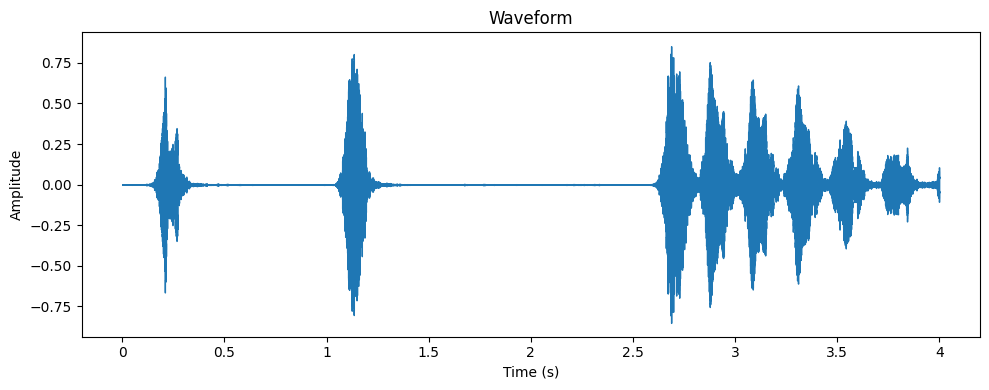

In [39]:
def display_waveform(audio_file, sr=44100):
    """
    Generates and displays the waveform of the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Display the waveform
display_waveform(input_audio_path)
ipd.Audio(input_audio_path)

##### Waveform plot for a specific audio file

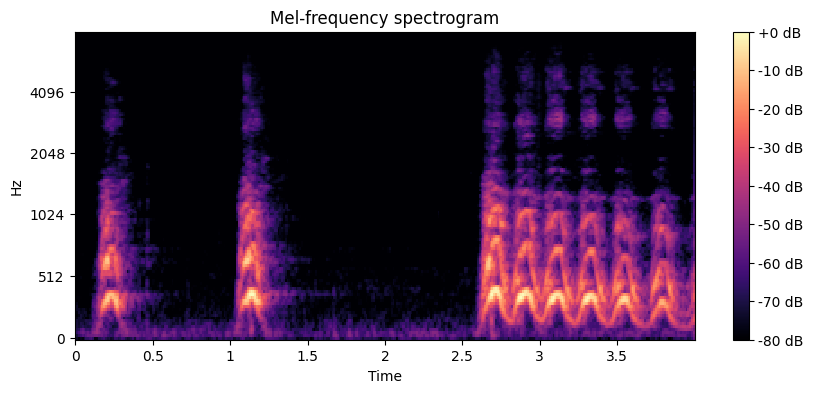

In [40]:
def display_spectrogram(audio_file, sr=44100, fmax=8000):
    """
    Generates and displays a mel-frequency spectrogram for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        fmax (int): Maximum frequency for the mel-frequency spectrogram (default: 8000).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

    # Display the image in the notebook
    plt.show()

# Input audio path
input_audio_path = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

# Generate and display the spectrogram
display_spectrogram(input_audio_path)

##### MFCCs for a specific audio file

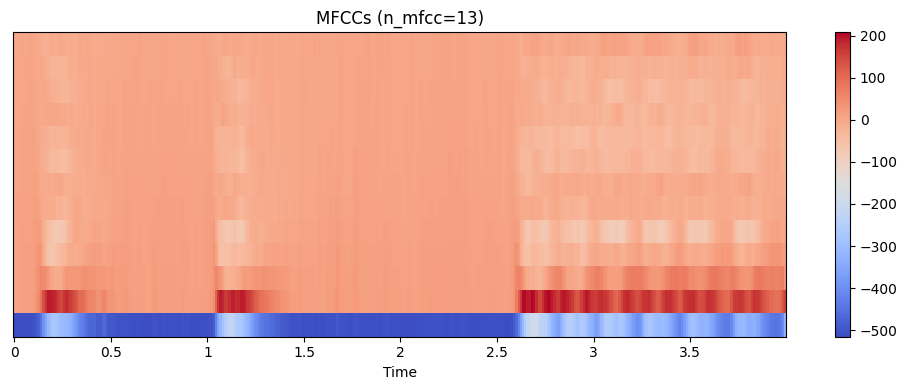

In [41]:
def display_mfcc(audio_file, sr=44100, n_mfcc=13):
    """
    Generates and displays the MFCCs for the given audio file.

    Args:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate of the audio (default: 44100).
        n_mfcc (int): Number of MFCCs to extract (default: 13).
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=sr)

    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.title(f'MFCCs (n_mfcc={n_mfcc})')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Input audio path
input_audio_path = "UrbanSound8K/audio/fold1/101415-3-0-2.wav"

# Display the MFCCs
display_mfcc(input_audio_path)

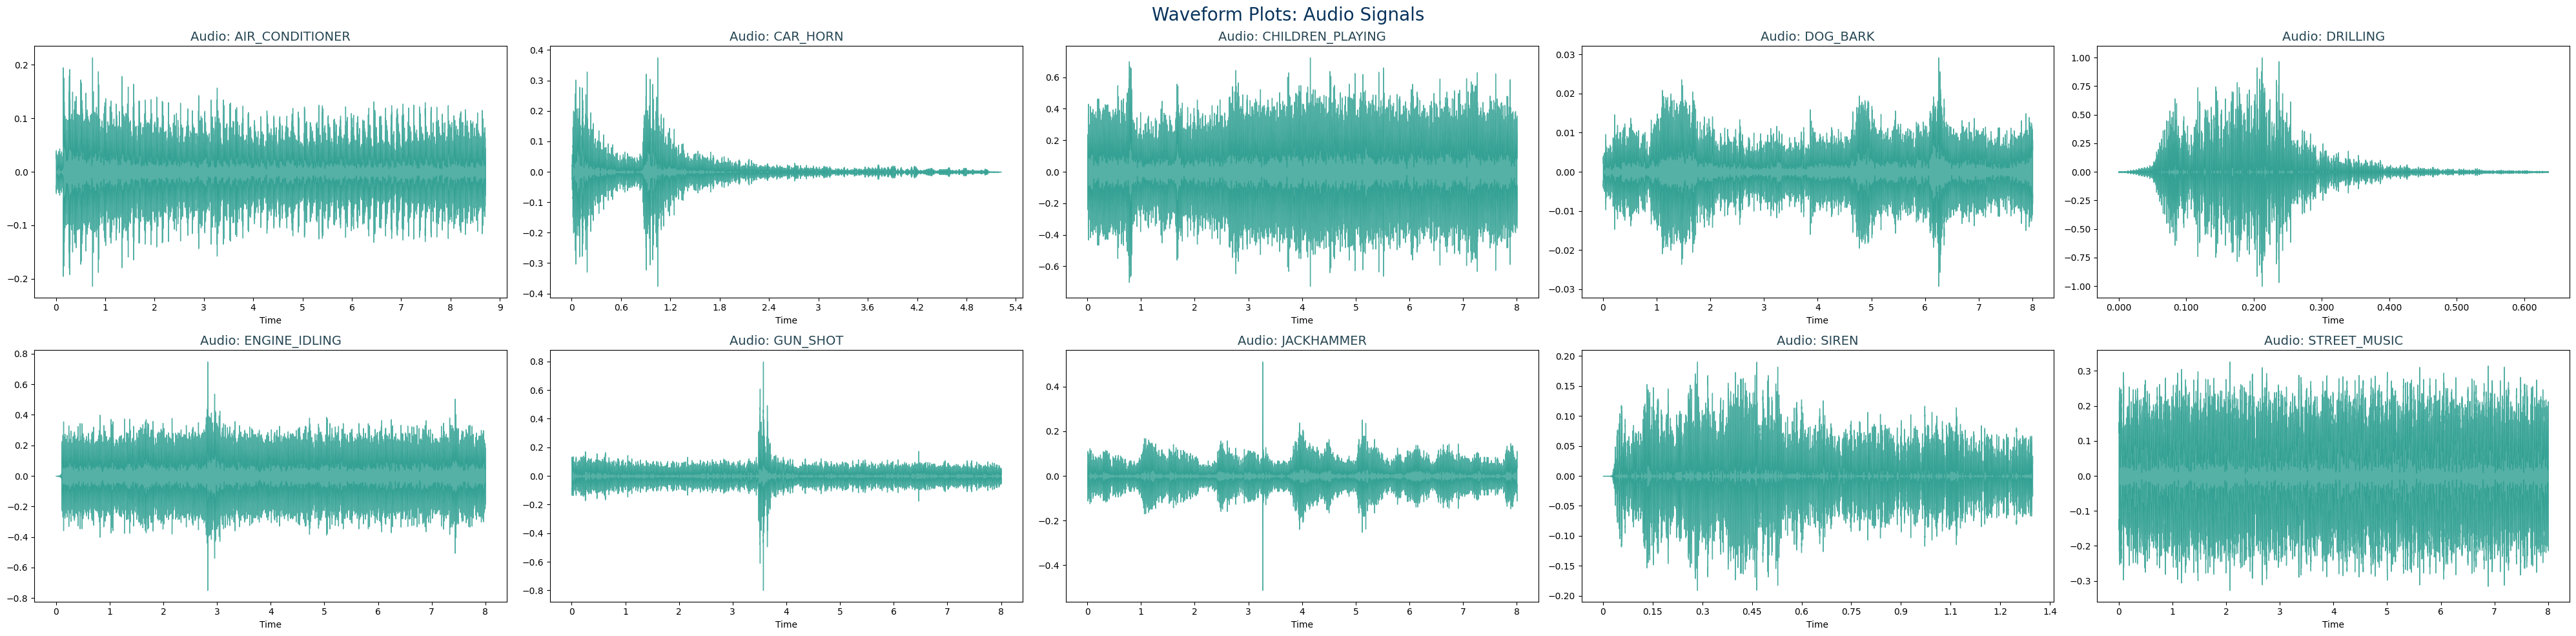

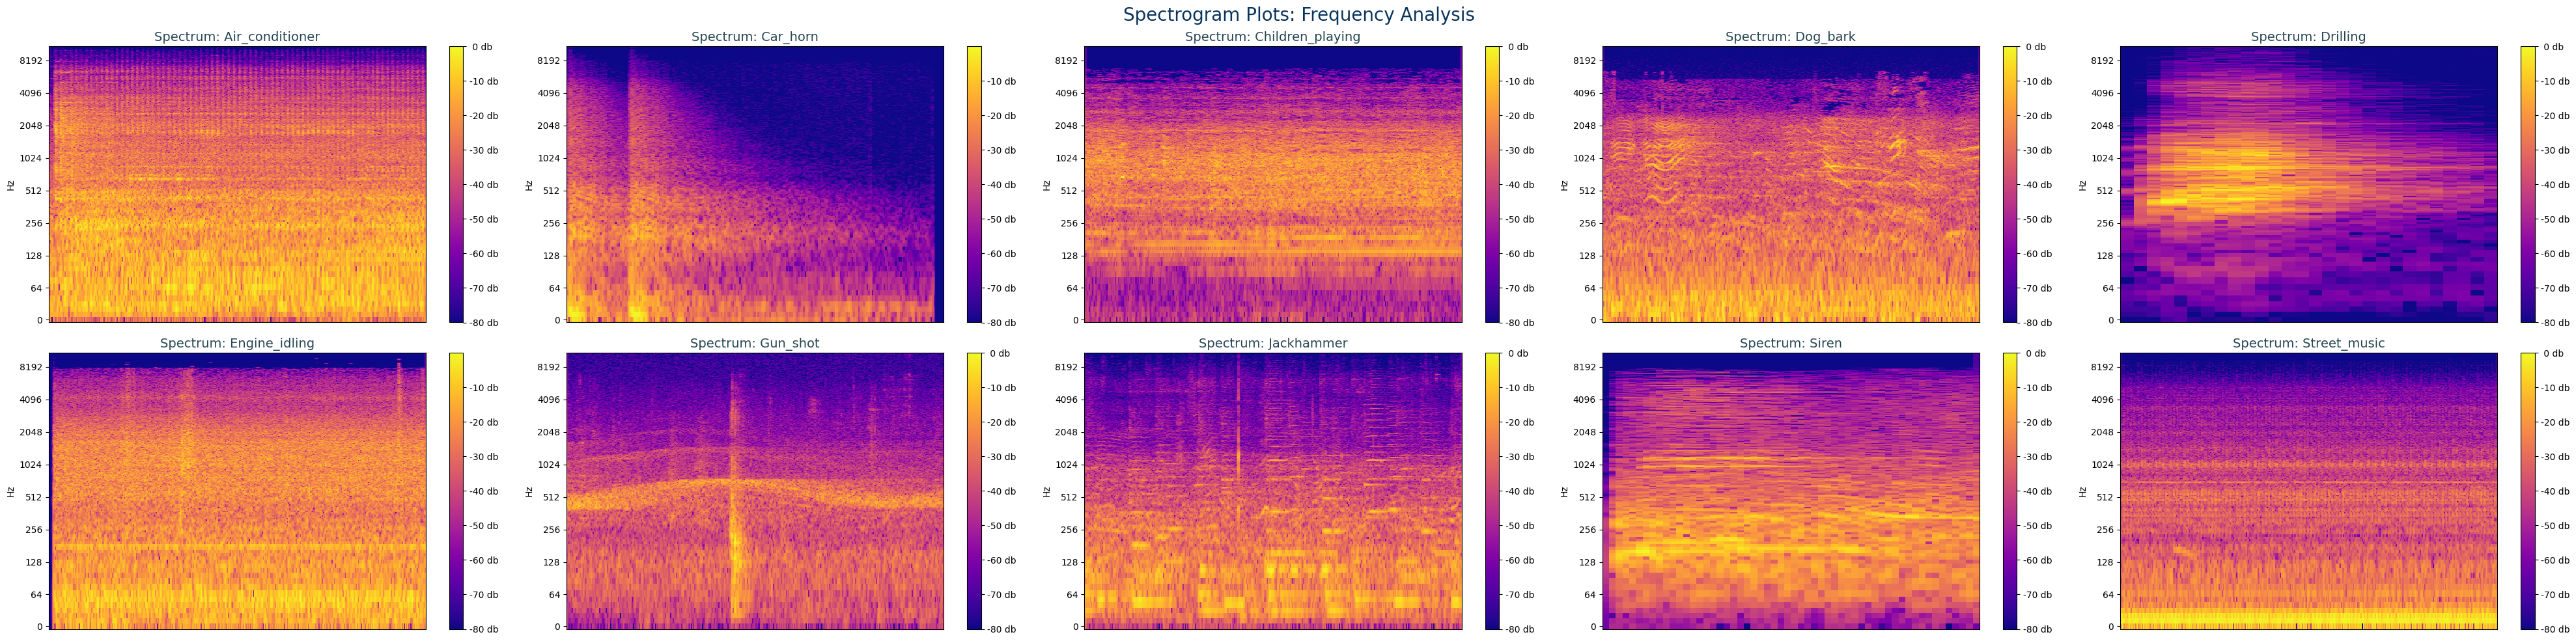

In [42]:
# Function to load audio files
def load_sound_files(file_paths):
    raw_sounds= []
    for fp in file_paths:
        x, sr = librosa.load(fp, sr=None)
        raw_sounds.append(x)
    return raw_sounds

# Function to plot the audio waveform
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10)) # Larger figure size for better viewing

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        librosa.display.waveshow(np.array(f), sr=22050, color='#2a9d8f', alpha=0.8, where='post') # Blue-green color
        plt.title(f"Audio: {n.upper()}", fontsize=14, color = '#264653') # Titles with a darker tone
        i += 1

    fig.suptitle("Waveform Plots: Audio Signals", fontsize=20, color='#09345c') # Main title in yellow
    plt.tight_layout()
    plt.show()

# Function to plot the audio spectrogram
def plot_spec(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10)) # Adjusted figure size

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        d = librosa.amplitude_to_db(np.abs(librosa.stft(f)), ref=np.max)
        librosa.display.specshow(d, y_axis='log', cmap='plasma') # Spectrogram with 'plasma' color map
        plt.colorbar(format='%2.0f db')
        plt.title(f"Spectrum: {n.capitalize()}", fontsize=14, color = '#264653') # Title with darker color
        i += 1

    fig.suptitle("Spectrogram Plots: Frequency Analysis", fontsize=20, color='#09345c') # Main title
    plt.tight_layout()
    plt.show()

# Set csv file path and get class list
path_csv = "UrbanSound8K/metadata/UrbanSound8K.csv"
df = pd.read_csv(path_csv)

# Get list of classes from 'class' column in csv
classes = list(np.unique(df['class']))

# Generate the list of audio files paths for viewing
sound_file_paths = [
    os.path.join('UrbanSound8K', 'audio', 'fold1', '103074-7-1-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '102305-6-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold3', '103199-4-0-3.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5','100263-2-0-117.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5','100032-3-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5','100852-0-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7','102853-8-0-2.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7','101848-9-0-9.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10','100648-1-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '102857-5-0-0.wav')
]

# Upload the audios
raw_sounds = load_sound_files(sound_file_paths)

# Plot Waveforms and Spectrograms
plot_waves(classes, raw_sounds)
plot_spec(classes, raw_sounds)  

Label Distribution Across Data Folds

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11140\4189253459.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fold_data['class'], ax=axs[row, col], palette='tab10')


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11140\4189253459.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fold_data['class'], ax=axs[row, col], palette='tab10')
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11140\4189253459.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fold_data['class'], ax=axs[row, col], palette='tab10')
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11140\4189253459.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fold_data['class'], ax=axs[row, col], palette='tab10')
C:\Users\Util

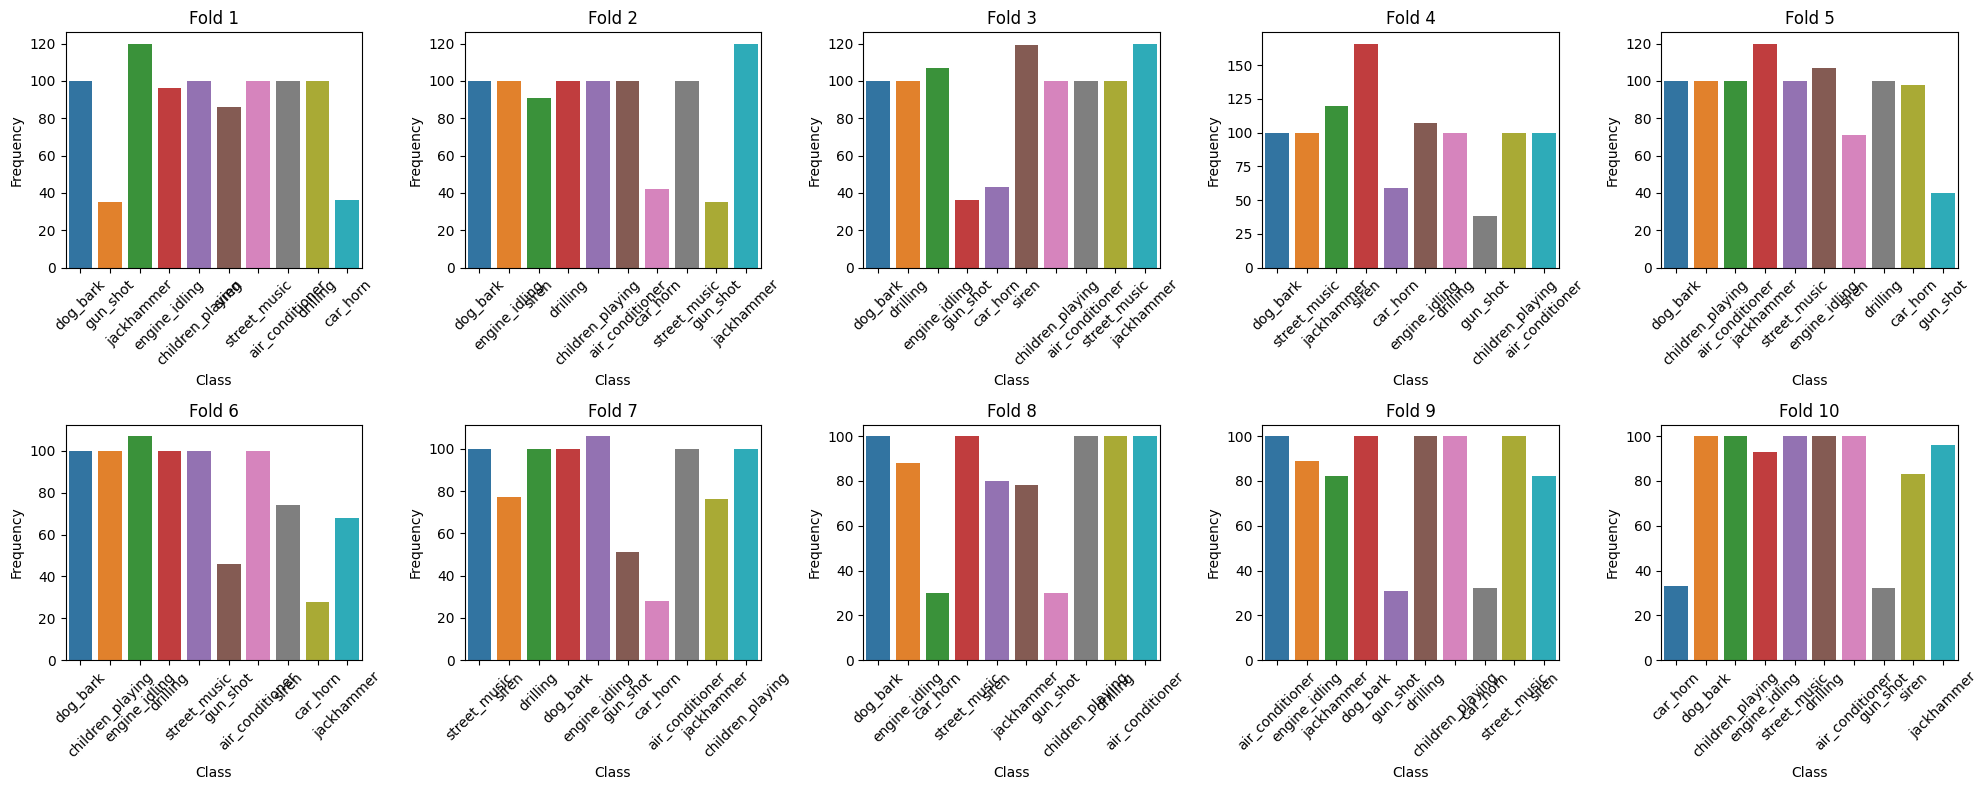

In [46]:
def plot_label_distribution_all_folds(csv_path, n_folds):
    """
    Plots the class distribution for each fold based on the UrbanSound8k metadata CSV file.
    
    :param csv_path: Path to the UrbanSound8k.csv file.
    :param n_folds: Total number of folds in the dataset.
    """
    # Load the CSV containing fold and class information
    df = pd.read_csv(csv_path)

    # Configure subplots
    nrows, ncols = 2, 5 
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,8))

    for fold_number in range(1, n_folds + 1):
        # Filter samples for teh current fold
        fold_data = df[df['fold'] == fold_number]

        # Determine subplot position
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols

        # Plot Histogram Of Classes
        sns.countplot(x=fold_data['class'], ax=axs[row, col], palette='tab10')
        axs[row, col].set_title(f'Fold {fold_number}')
        axs[row, col].set_xlabel('Class')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
csv_path = "UrbanSound8K/metadata/UrbanSound8k.csv"
plot_label_distribution_all_folds(csv_path, 10)

In this section, we will perform data cleaning. This process will include the following steps:

- Check for Missing Values
- Check if there are any columns with object type
- Check for Duplicates
- Validate Column Data Types
- Normalization
- Label Encoding 

### Missing values

In [47]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print(f" - Missing values detected:\n{missing_values[missing_values > 0]}")
    else:
        print(" - No missing values detected.")

### Columns with object type

In [48]:
def check_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    if object_columns.any():
        print(f" - Columns with object data type: {object_columns.tolist()}")
    else:
        print(" - No columns with object data type detected.")

### Duplicates

In [49]:
def check_duplicates(df):
    if duplicates > 0:
        print(f" - {duplicates} duplicate rows found.")
        df = df.drop_duplicates()
    else:
        print(" - No duplicate rows detected.")
    return df   

### Column Data Types

In [50]:
def validate_columns_data_types(df):
    column_data_types = df.dtypes
    print(f" - Column data types:\n{column_data_types}")

### Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    # Normalize numerical columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_columns) > 0:
        scaler = MinMaxScaler()
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
        print(f"Normalized values:\n{df[numeric_columns].describe()}")
        print(f" - Normalized numeric columns: {numeric_columns.tolist()}")

    # Processar a coluna Label (se existir)
    if 'Label' in df.columns:
        df['Label'] = df['Label'].apply(
            lambda x: int(x.split('-')[1]) if isinstance(x, str) and len(x.split('-')) > 1 else None
        )
        print(f"Updated 'Label' column to 'classID' values.")

    return df

### Fourier Tempogram Normalization

In [52]:
def normalize_fourier_tempogram(df):
    """
    Normalizes the 'fourier_tempogram' column in the DataFrame using MinMaxScaler.
    """
    if 'fourier_tempogram' in df.columns:
        sclaer = MinMaxScaler()
        df[['fourier_tempogram']] = scaler.fit_transform(df[['fourier_tempogram']])
        print(" - 'fourier_tempogram' normalized.")

    else:
        print(" - 'fourier_tempogram' column not found. Skipping normalization.")
    return df

### Label Encoding 

In [53]:
def label_encode_data(df):
    """
    Performs Label Encoding on all object-type columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        df (pd.DataFrame): DataFrame with Label Encoding applied.
    """
    object_cols = df.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        for col in object_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f" - Label Encoding Applied To Column: {col}")
    else:
        print(" - No Columns Found For Label Encoding.")
    return df

### Putting it All Together

In [64]:
file__path = pd.read_csv("UrbanSound8K/metadata/UrbanSound8k.csv")
path = "UrbanSound8K/metadata/UrbanSound8k.csv"

df = check_missing_values(file_path)
df = check_object_columns(file_path)
df = check_duplicates(file_path)
df = normalize_data(file_path)
df = normalize_fourier_tempogram(file_path)
df = label_encode_data(file_path)

# Save the cleaned DataFrame to the same file
df.to_csv(path, index=False)
print(f"  - Cleaned data saved to: {path}")

 - No missing values detected.
 - No columns with object data type detected.
 - No duplicate rows detected.
Normalized values:
              fsID        start          end     salience         fold  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean      0.551827     0.064396     0.069778     0.347000     0.487326   
std       0.276611     0.123794     0.123125     0.476043     0.316313   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.331977     0.004999     0.011148     0.000000     0.222222   
50%       0.562538     0.017291     0.023003     0.000000     0.444444   
75%       0.794656     0.058540     0.064172     1.000000     0.777778   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           classID  
count  8732.000000  
mean      0.510320  
std       0.321616  
min       0.000000  
25%       0.222222  
50%       0.444444  
75%       0.777778  
max       1.000000  
 - Normalized num

## Modeling<a name = "modeling"></a>
[back to top](#contents)

Since we are done with all data understanding and preparation, we are now ready to begin the implementation of our chosen models.
From now on, the project is divided into two separate notebooks: 
- **[CNN](./CNN.ipynb)** - focused on the implementation and evaluation of the Convolutional Neural Network classifier.
- **[RNN](./RNN.ipynb)** - dedicated to the development and analysis of the Recurrent Neural Network classifier.

This separation ensures a clearer organization of the workflow, avoids mixing different architectures in the same document, and makes the project easier to follow and maintain.